In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import DSH
from DSH import Kernel
from DSH import MIfile as MI
from DSH import CorrMaps as CM

# Load MI file

```MIfile``` class interacts with MIfiles: read them and write them, and handles metadata from external configuration files.
To load a MIfile together with associated metadata, use:

```python
mi_file = MI.MIfile(MI_filename, Metadata_filename)
```

In [2]:
froot = os.path.join(os.path.dirname(MI.__file__), 'test')
fname = os.path.join(froot, 'MIfile.dat')
metadata_fname = os.path.join(froot, 'metadata.ini')
mi_file = MI.MIfile(fname, metadata_fname)

```MIfile``` class doesn't load any data from the source MIfile upon initializion.
Data can be retrieved using one of the following functions:

```python
mi_file.Read(zRange=None, cropROI=None, closeAfter=False) #Read multiple images or ROIs from MIfile
mi_file.GetImage(img_idx, cropROI=None) #Read single image or ROI from MIfile
mi_file.GetStack(start_idx=0, imgs_num=-1) #Read contiguous image stack from MIfile
```

Here, ```cropROI``` has to be a 4-element tuple of the form: ```[x, x, w, h]```, 
where ```(x, y)``` is the coordinate of the top-left corner of the ROI (0-based) 
and ```(w, h)``` are width and height, respectively. Setting either ```w``` or ```h``` to ```-1```
indicates that the dimension extends to the image boundary.

Before any reading operation, file handle must be initialized using 

```python
mi_file.OpenForReading()
```

At the end of any reading operation, file handle must be freed using

```python
mi_file.Close()
```

### Test MIfile class

The structure of the MIfile class can be print to output in two ways:

In [3]:
mi_file

<MIfile: 0+2x200x300x1 bytes>

In [4]:
print(mi_file)


|---------------|
| MIfile class: |
|---------------+---------------
| Filename      : C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\test\MIfile.dat
| Header        : 0 bytes
| Shape         : [2, 200, 300] px
| Pixel format  : B (1 bytes/px)
|---------------+---------------


To get a feeling of what's inside the MIfile let's display one random frame:

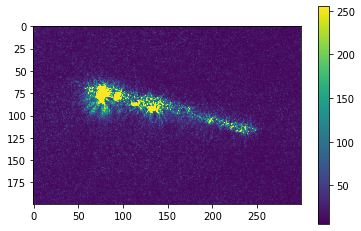

In [5]:
mi_file.OpenForReading()
sample_ROI = mi_file.GetImage(0)
plt.imshow(sample_ROI)
plt.colorbar()

Each MIfile has associated metadata, contained in a ```DSH.Config``` object:

In [6]:
mi_file.MetaData

<Config class: 2 sections, 7 keys>

In [7]:
print(mi_file.MetaData)


|---------------|
| Config class: |
|---------------+---------------
| Section count : 2
| Total keys    : 7
| MIfile        : <6 keys>
|                 hdr_len = 0
|                 px_format = B
|                 fps = 10
|                 px_size = 1
|                 shape = [2, 200, 300]
|                 comments = sample multi image MIfile
| settings      : <1 keys>
|                 max_buffer_size = 100000000
|---------------+---------------


```MIfile```-specific metadata can be exported as a dictionary by calling ```mi_file.GetMetadata()```:

In [8]:
mi_file.GetMetadata()

OrderedDict([('hdr_len', '0'),
             ('px_format', 'B'),
             ('fps', '10'),
             ('px_size', '1'),
             ('shape', '[2, 200, 300]'),
             ('comments', 'sample multi image MIfile')])

### Export MIfile

To export a chunk of MIfile, we can use:

```python
mi_file.Export(mi_filename, metadata_filename, zRange=None, cropROI=None)
```

In [9]:
exp_mi_fname = os.path.join(froot,'MIfile_2.dat')
exp_meta_fname = os.path.join(froot,'metadata_2.ini')
test_ROI = [200, 100, -1, 50]
mi_file.Export(exp_mi_fname, exp_meta_fname, zRange=[0, 1], cropROI=test_ROI)

Let's test that the export was successful:

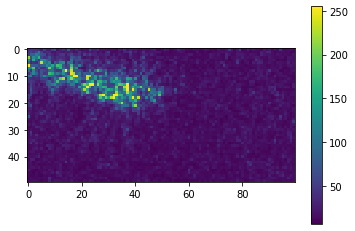

In [10]:
exp_mi_file = MI.MIfile(exp_mi_fname, exp_meta_fname)
exp_mi_file.OpenForReading()
plt.imshow(exp_mi_file.GetImage(0))
plt.colorbar()

# Correlation maps

```MIfile``` class can also be used as an input for ```CorrMaps``` class, which computes correlation maps.
We initialize a ```CorrMaps``` class like this:

```python
corrmap = CM.CorrMaps(MIin, outFolder, lagList, KernelSpecs, imgRange=None, cropROI=None)
```

where:
- ```MIin``` is the input ```MIfile``` class
- ```outFolder``` (```str```) is the output folder where correlation maps will be saved
- ```lagList``` is a list of lagtimes (```int```, in image units, independent on the step specified in ```imgRange```). One correlation map will be computer for each lagtime
- ```KernelSpecs``` is a ```DSH.Kernel``` object containing the parameters for local averaging. It can be initialized using ```DSH.Kernel()``` and initialized using ```Kernel.initialize(shape, kernel_type, params={}, n_dim=2, padding=False, convolve_kwargs={})```, where:
    - ```shape``` (```int``` or n-dimensional list of ```int```) is the shape of the output kernel matrix.
    - ```kernel_type``` (```str```) is the kernel type. For the moment the only supported types are ```'flat'```, a uniform kernel, and ```'Gauss'```, a Gaussian kernel, which requires specification of ```'sigma'``` (```float``` or n-dimensional tuple), the Gaussian standard deviation. Eventual additional parameters are specified in the ```params``` variable (```dict```).
    - ```n_dim``` (```int```) is the number of dimensions
    - ```padding``` (```bool```): if ```True```, the input images will be padded with zeroes such that the output correlation maps will have the same shape as the input images. Otherwise, the correlation maps will have the margins trimmed of an amount equal to the kernel size.
    - ```convolve_kwargs``` is a ```dict``` containing eventual extra keywords that will be passed to ```scipy.signal.convolve2d```
- ```imgRange``` is a list of 3 ```int``` of the form ```[z_min, z_max, z_step]```.
- ```cropROI``` contains ROI specs in the same form as the one specified for MIfile class

<Kernel [2D Gauss], 11x11, s=(2.5;1.5)>


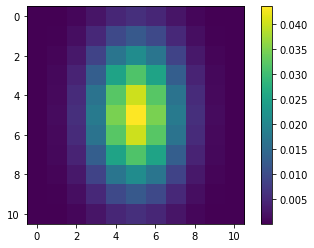

In [11]:
KernelSpecs = DSH.Kernel.Kernel()
KernelSpecs.Initialize(shape=11, kernel_type='Gauss', params={'sigma':[2.5, 1.5]}, padding=True)
print(KernelSpecs)
plt.imshow(KernelSpecs.ToMatrix())
plt.colorbar()

In [12]:
corrmap = CM.CorrMaps(mi_file, froot, [1], KernelSpecs, imgRange=None, cropROI=test_ROI)

Once again, initialization only computes analysis parameters. To actually compute the correlation maps we need to call:

```python
cmap_list = corrmap.Compute(silent=True, return_maps=False)
```

Correlation maps will only returned if argument ```return_maps``` is set to ```True```. However, be aware that this may lead to heavy memory usage, and that no memory check will be done. When ```return_maps==False```, ```None``` will be returned. For testing purposes, we compute correlation maps on a small subset of the MIfile, and we return the output

In [13]:
cmap_list = corrmap.Compute(silent=False, return_maps=True)

Computing correlation maps:
  STEP 1: Loading images and computing average intensity...
  STEP 2: Computing contrast...
  STEP 3: Computing correlations...
     ...lag 1
Procedure completed in 0.0 seconds!


check out one random frame from each correlation map:

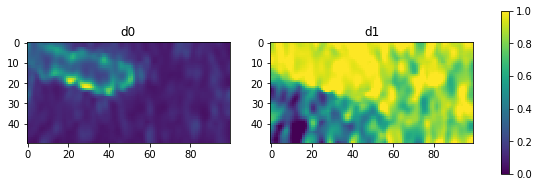

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
tidx = 0
lagidx = 1
ax1.set_title('d0')
ax1.imshow(cmap_list[0][tidx], vmin=0.0, vmax=1.0)
ax2.set_title('d'+str(lagidx))
cbar = ax2.imshow(cmap_list[lagidx][tidx], vmin=0.0, vmax=1.0)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.5)

once again, details about the CorrMap class instance can be printed to output by simply doing:

In [15]:
print(corrmap)


|-----------------|
| CorrMaps class: |
|-----------------+---------------
| MI Filename     : C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\test\MIfile.dat
| output folder   : C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\test
| lag times (01)  : [1]
| image range     : [0, 2, 1]
| crop ROI        : [200, 100, 100, 50]
| Kernel          : <Kernel [2D Gauss], 11x11, s=(2.5;1.5)>
|-----------------+---------------


let's see what happens if we don't use padding:

In [16]:
KernelSpecs.SetPadding(False)
corrmap_nopad = CM.CorrMaps(mi_file, froot, [1], KernelSpecs, imgRange=None, cropROI=test_ROI)
cmap_list_nopad = corrmap_nopad.Compute(silent=False, return_maps=True)

AttributeError: 'dict' object has no attribute 'Padding'

NameError: name 'cmap_list_nopad' is not defined

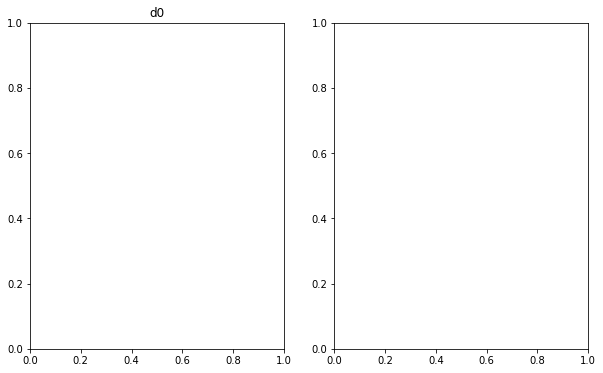

Exception ignored in: <function CorrMaps.__del__ at 0x00000161E8270EE8>
Traceback (most recent call last):
  File "C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\CorrMaps.py", line 112, in __del__
    self.CloseMaps()
  File "C:\Users\steaime\Documents\Codes\DSH\DSHpy\DSH\CorrMaps.py", line 256, in CloseMaps
    self.cmapStack.CloseAll()
AttributeError: 'CorrMaps' object has no attribute 'cmapStack'


In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.set_title('d0')
ax1.imshow(cmap_list_nopad[0][tidx], vmin=0.0, vmax=1.0)
ax2.set_title('d'+str(lagidx))
cbar = ax2.imshow(cmap_list_nopad[lagidx][tidx], vmin=0.0, vmax=1.0)
fig.colorbar(cbar, ax=[ax1, ax2], shrink=0.5)

To check that everywhere away from the boundary the two methods are the same we compute the difference:

In [17]:
print(np.max(np.absolute(np.subtract(cmap_list[1][:, 5:-5, 5:-5],cmap_list_nopad[1]))))

1.2418478e-11
